In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

In [2]:
caminho_arquivo = './dados/MICRODADOS_ENEM_2023.csv'
data = pd.read_csv(caminho_arquivo, encoding='latin1', sep=';')
num_columns = data.shape[1]
num_rows = data.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
data.head()

Número de colunas: 76
Número de linhas: 3933955


,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210059085136,2023,14,M,2,1,1,1,17,1,...,C,C,B,B,A,B,B,A,A,B
1,210059527735,2023,12,M,2,1,0,1,16,1,...,B,A,B,B,A,A,C,A,D,B
2,210061103945,2023,6,F,1,1,1,1,0,1,...,B,A,A,B,A,A,A,A,A,B
3,210060214087,2023,2,F,1,3,1,2,0,2,...,A,A,A,B,A,A,D,A,A,B
4,210059980948,2023,3,F,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,A,A


In [3]:
#função tratar nulos
def tratarNulos(dados):
    dataset = dados.copy()  # evita problemas de referência
    
    # Colunas numéricas que representam categorias
    colunas_categoricas_numericas = [
        'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
        'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
        'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC','Q006',
        'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019'
    ]
    
    for col in dataset.columns:
        if dataset[col].isnull().any():  # só trata se houver nulos
            if col in colunas_categoricas_numericas:
                # Para categóricas → moda
                moda = dataset[col].mode()
                if not moda.empty:
                    dataset[col] = dataset[col].fillna(moda.iloc[0])
            else:
                # Para numéricas contínuas → média
                media = dataset[col].mean()
                dataset[col] = dataset[col].fillna(media)
    
    return dataset

In [4]:
dados_selecionados = data[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO','Q006', 'Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016',
                       'Q017','Q018','Q019']]

In [5]:
print("Antes:")
print(dados_selecionados.isnull().sum()[data.isnull().sum() > 0])
dataset_sem_nulos  = tratarNulos(dados_selecionados)
print("\nDepois:")
print(dataset_sem_nulos.isnull().sum()[dataset_sem_nulos.isnull().sum() > 0])

Antes:
TP_ENSINO             2594874
TP_LOCALIZACAO_ESC    2975449
NU_NOTA_CN            1241528
NU_NOTA_CH            1111312
NU_NOTA_LC            1111312
NU_NOTA_MT            1241528
NU_NOTA_REDACAO       1111312
dtype: int64

Depois:
Series([], dtype: int64)


In [6]:
# Dicionário para mapear as respostas da questão Q006 (faixa de renda) em classes sociais
mapa_renda = {
    'A': 'E',
    'B': 'D',
    'C': 'D',
    'D': 'C',
    'E': 'C',
    'F': 'B',
    'G': 'B',
    'H': 'A',
    'I': 'A',
    'J': 'A',
    'K': 'A',
    'L': 'A',
    'M': 'A',
    'N': 'A',
    'O': 'A',
    'P': 'A',
    'Q': 'A'
}

# Criar nova coluna 'classe_social' baseada na resposta da questão Q006
dataset_sem_nulos['classe_social'] = dataset_sem_nulos['Q006'].map(mapa_renda)
dataset_sem_nulos = dataset_sem_nulos.drop(columns=['Q006'])

In [7]:
num_columns = dataset_sem_nulos.shape[1]
num_rows = dataset_sem_nulos.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
dataset_sem_nulos.head()

Número de colunas: 29
Número de linhas: 3933955


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_LOCALIZACAO_ESC,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,classe_social
0,14,M,2,1,1,1,17,1,1.0,1.0,...,D,C,B,B,D,C,C,B,B,B
1,12,M,2,1,0,1,16,1,1.0,1.0,...,A,B,B,B,A,B,A,B,B,A
2,6,F,1,1,1,1,0,1,1.0,1.0,...,A,B,A,B,A,B,A,A,B,D
3,2,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,D
4,3,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,D


In [8]:
# 1. Separar X e y
X = dataset_sem_nulos.drop(columns=['classe_social'])
y = dataset_sem_nulos['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('classificador', clf) 
])



# 6. Treinar modelo
modelo.fit(X, y)

# 7. Avaliar
y_pred = modelo.predict(X)
print("Acurácia:", accuracy_score(y, y_pred))
print("\nRelatório de classificação:\n", classification_report(y, y_pred))
print("\nMatriz de confusão:\n", confusion_matrix(y, y_pred))

# 8. Visualizar a árvore em texto
arvore_texto = export_text(modelo.named_steps['classificador'],
                           feature_names=modelo.named_steps['preprocessador'].get_feature_names_out())
print(arvore_texto)

Acurácia: 0.942172953173079

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.98      0.98      0.98    605658
           B       0.96      0.94      0.95    432671
           C       0.94      0.90      0.92    731360
           D       0.92      0.98      0.95   1896213
           E       0.99      0.73      0.84    268053

    accuracy                           0.94   3933955
   macro avg       0.96      0.90      0.93   3933955
weighted avg       0.94      0.94      0.94   3933955


Matriz de confusão:
 [[ 594688    1967    4096    4892      15]
 [   5049  404709    7627   15253      33]
 [   5448    7820  655761   62108     223]
 [   3982    7500   26309 1855906    2516]
 [    305     587    2357   69402  195402]]
|--- cat__Q010_A <= 0.50
|   |--- cat__Q008_B <= 0.50
|   |   |--- cat__Q007_A <= 0.50
|   |   |   |--- cat__Q008_C <= 0.50
|   |   |   |   |--- cat__Q018_A <= 0.50
|   |   |   |   |   |--- cat__Q008_E <= 0.50
|   |

In [ ]:
feature_names = modelo.named_steps['preprocessador'].get_feature_names_out()

# Pegar as classes
class_names = modelo.named_steps['classificador'].classes_
plt.figure(figsize=(20,10))
plot_tree(
    modelo.named_steps['classificador'],   # árvore treinada dentro do pipeline
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()

77
Importância das features:
Feature Q010_A: 0.1297
Feature NU_NOTA_MT: 0.1060
Feature NU_NOTA_LC: 0.0993
Feature NU_NOTA_CH: 0.0989
Feature NU_NOTA_CN: 0.0945
Feature NU_NOTA_REDACAO: 0.0676
Feature TP_FAIXA_ETARIA: 0.0508
Feature Q008_B: 0.0434
Feature TP_COR_RACA: 0.0319
Feature TP_ANO_CONCLUIU: 0.0304
Feature Q007_A: 0.0215
Feature Q014_A: 0.0169
Feature TP_ESTADO_CIVIL: 0.0161
Feature Q018_B: 0.0135
Feature Q011_A: 0.0091
Feature TP_ESCOLA: 0.0083
Feature Q011_B: 0.0082
Feature TP_SEXO_F: 0.0082
Feature TP_SEXO_M: 0.0081
Feature Q009_D: 0.0075
Feature Q009_C: 0.0075
Feature TP_ST_CONCLUSAO: 0.0074
Feature Q013_A: 0.0072
Feature Q016_A: 0.0065
Feature Q008_C: 0.0065
Feature Q013_B: 0.0065
Feature Q015_A: 0.0063
Feature Q015_B: 0.0061
Feature TP_NACIONALIDADE: 0.0057
Feature Q018_A: 0.0055
Feature Q019_B: 0.0053
Feature Q016_B: 0.0038
Feature Q009_E: 0.0038
Feature Q009_B: 0.0036
Feature Q011_C: 0.0036
Feature Q012_B: 0.0035
Feature Q010_B: 0.0035
Feature Q019_C: 0.0032
Feature Q019

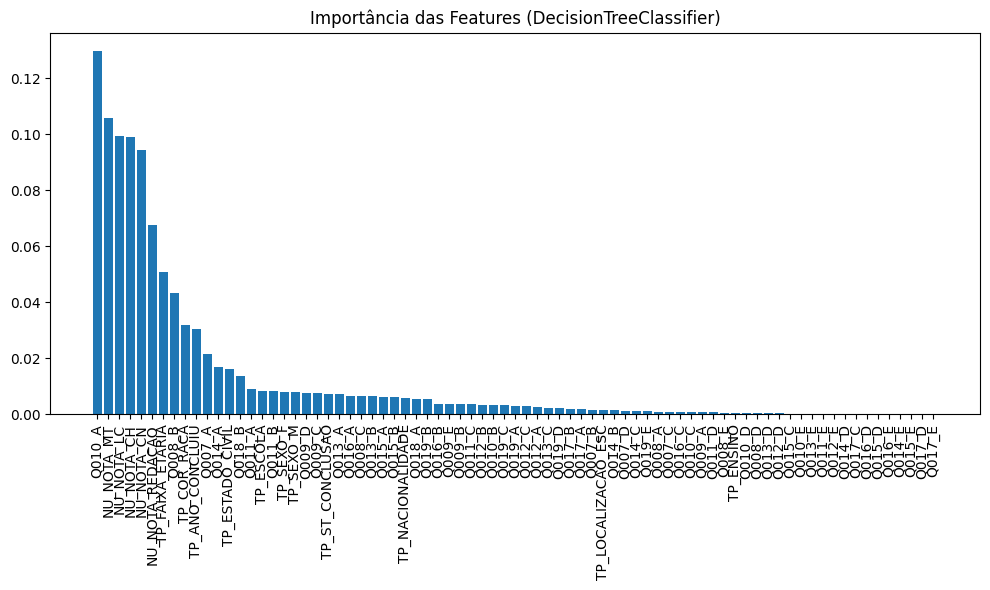

In [9]:
nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()
nomes_features = [nome.split("__")[1] for nome in nomes_features]

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # ordenar do mais importante pro menos
print(len(indices))


# Print em texto
print("Importância das features:")
#print(X)
for i in indices:
    print(f"Feature {nomes_features[i]}: {importances[i]:.4f}")

# 3. Gráfico
plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [nomes_features[i] for i in indices], rotation=90)
plt.title("Importância das Features (DecisionTreeClassifier)")
plt.tight_layout()
plt.show()

In [10]:
def analisar_quartis_por_classe(dataset):
    """
    Função para analisar a distribuição da classe social em cada quartil de notas.
    
    Parâmetros:
        dataset (pd.DataFrame): dataset com colunas 'NU_NOTA_CN', 'NU_NOTA_CH',
                                'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO' e 'classe_social'.
    
    Retorno:
        pd.DataFrame: tabela com distribuição percentual da classe social por quartil de notas.
    """

    # Cria uma coluna com a média das notas
    dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                                      'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

    # Divide em quartis
    dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4, 
                                       labels=['1º Quartil (mais baixo)', 
                                               '2º Quartil', 
                                               '3º Quartil', 
                                               '4º Quartil (mais alto)'])

    # Calcula a distribuição percentual
    tabela = (dataset.groupby('quartil_notas')['classe_social']
                     .value_counts(normalize=True)
                     .rename('proporcao')
                     .reset_index())

    # Transforma em tabela no formato que você mostrou
    tabela_pivot = tabela.pivot(index='quartil_notas', 
                                columns='classe_social', 
                                values='proporcao')

    print("\nDistribuição de classe social por quartil de notas:\n")
    print(tabela_pivot)

    return tabela_pivot

In [11]:
resultado_quartis_dataset_geral = analisar_quartis_por_classe(dataset_sem_nulos)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_9712\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (dataset.groupby('quartil_notas')['classe_social']



Distribuição de classe social por quartil de notas:

classe_social                   A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.057492  0.069125  0.160126  0.607340  0.105917
2º Quartil               0.087729  0.088998  0.187913  0.553041  0.082319
3º Quartil               0.157331  0.137551  0.223190  0.440768  0.041160
4º Quartil (mais alto)   0.353864  0.172567  0.192974  0.261434  0.019161


In [16]:
def analisar_quartis_com_modelo(modelo, X):
    # Faz as previsões
    y_pred = modelo.predict(X)

    # Cria DataFrame com notas + previsão
    df = X.copy()
    df['classe_prevista'] = y_pred
    df['media_notas'] = X[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                           'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

    # Divide em quartis
    df['quartil_notas'] = pd.qcut(df['media_notas'], 4,
                                  labels=['1º Quartil (mais baixo)',
                                          '2º Quartil',
                                          '3º Quartil',
                                          '4º Quartil (mais alto)'])

    # Tabela de distribuição
    tabela = (df.groupby('quartil_notas')['classe_prevista']
                .value_counts(normalize=True)
                .rename('proporcao')
                .reset_index())

    tabela_pivot = tabela.pivot(index='quartil_notas',
                                columns='classe_prevista',
                                values='proporcao')

    print("\nDistribuição da classe prevista pelo modelo em cada quartil de notas:\n")
    print(tabela_pivot)

    return tabela_pivot

In [17]:
resultado_modelo = analisar_quartis_com_modelo(modelo, X)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_9712\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']



Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.057492  0.069126  0.160129  0.607336  0.105917
2º Quartil               0.090179  0.082517  0.165291  0.624576  0.037438
3º Quartil               0.157331  0.137551  0.223190  0.440768  0.041160
4º Quartil (mais alto)   0.353864  0.172567  0.192974  0.261434  0.019161


In [ ]:
# Filtrar apenas escolas urbanas
dataset_urbano = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 1]

# Filtrar apenas escolas rurais
dataset_rural = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 2]